In [1]:
import os
import pandas as pd
import numpy as np
import multiprocessing as mp

from commons import vizwiz as vw
from commons import images as im
from itertools import repeat
from IPython.core.display import HTML

from tqdm import tqdm
tqdm.pandas()

# %pip install opencv-python-headless

### Analyzing the train data

In [2]:
vizwiz = vw.VizWiz(annotation_file='annotations/train.json')

loading annotations into memory...
Done (t=0.29s)
creating index...
index created! imgs = 23431, anns = 100575


In [3]:
vizwiz_df = pd.DataFrame.from_dict(vizwiz.dataset['annotations'], orient='columns')
vizwiz_images_df = pd.DataFrame.from_dict(vizwiz.dataset['images'], orient='columns')

vizwiz_df = vizwiz_df.merge(vizwiz_images_df.rename({'id': 'image_id', 'text_detected': 'image_text_detected'}, axis=1), 
                            on='image_id', how='left')

In [4]:
# caption counts for each image
vizwiz_df['captions_count'] = vizwiz_df.groupby(by=['image_id'])['caption'].transform('count')

# word counts for each caption
vizwiz_df['words_count'] = vizwiz_df['caption'].str.split().apply(len)

# https://stackoverflow.com/questions/61299310/pandas-groupby-with-custom-function-to-return-the-column-values-as-an-array

In [5]:
%%time

# create df with unique image id and file name
cols = ['image_id', 'file_name']
vizwiz_unique = vizwiz_df.groupby(by=cols, as_index=False).first()[cols]

# find dimension for each image
bucket = 'assistive-vision'
train_imgs = 'vizwiz/train'

images = im.ImageS3(bucket)

def dimension(path, f):
    fpath = ''.join([path, '/', f])
    img = images.getImage(fpath)
    return img.shape

#vizwiz_unique['shape'] = vizwiz_unique['file_name'].progress_apply(lambda f: dimension(f))

# parallelize the tasks to available cpu cores
with mp.Pool(mp.cpu_count()) as pool:
    vizwiz_unique['shape'] = pool.starmap(dimension, zip(repeat(train_imgs), vizwiz_unique['file_name']))

CPU times: user 835 ms, sys: 282 ms, total: 1.12 s
Wall time: 18min 28s


In [6]:

vizwiz_unique.drop(columns=['file_name'], inplace=True)
vizwiz_df = vizwiz_df.merge(vizwiz_unique, on='image_id', how='left')


In [7]:
display(HTML(vizwiz_df.head().to_html()))

,caption,image_id,is_precanned,is_rejected,id,text_detected,file_name,vizwiz_url,image_text_detected,captions_count,words_count,shape
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.,0,False,False,0,True,VizWiz_train_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_train_00000000.jpg,True,4,12,"(1632, 1224, 3)"
1,A green and white plastic condiment bottle containing Basil leaves.,0,False,False,1,True,VizWiz_train_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_train_00000000.jpg,True,4,10,"(1632, 1224, 3)"
2,A bottle of spices in a plastic container laying on a surface.,0,False,False,3,True,VizWiz_train_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_train_00000000.jpg,True,4,12,"(1632, 1224, 3)"
3,some basil leaves in a container on a counter,0,False,False,4,True,VizWiz_train_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_train_00000000.jpg,True,4,9,"(1632, 1224, 3)"
4,"A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.",1,False,False,5,True,VizWiz_train_00000001.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_train_00000001.jpg,True,5,19,"(1296, 968, 3)"


In [8]:
vizwiz_df['height'], vizwiz_df['width'], _ = zip(*vizwiz_df['shape'])

### Next is the val data

In [9]:
vizwiz_val = vw.VizWiz(annotation_file='annotations/val.json')

loading annotations into memory...
Done (t=0.12s)
creating index...
index created! imgs = 7750, anns = 33145


In [10]:
vizwiz_val_df = pd.DataFrame.from_dict(vizwiz_val.dataset['annotations'], orient='columns')
vizwiz_images_val_df = pd.DataFrame.from_dict(vizwiz_val.dataset['images'], orient='columns')

vizwiz_val_df = vizwiz_val_df.merge(vizwiz_images_val_df.rename({'id': 'image_id', 'text_detected': 'image_text_detected'}, axis=1), 
                            on='image_id', how='left')

In [11]:
# caption counts for each image
vizwiz_val_df['captions_count'] = vizwiz_val_df.groupby(by=['image_id'])['caption'].transform('count')

# word counts for each caption
vizwiz_val_df['words_count'] = vizwiz_val_df['caption'].str.split().apply(len)


In [12]:
%%time

# create df with unique image id and file name
cols = ['image_id', 'file_name']
vizwiz_val_unique = vizwiz_val_df.groupby(by=cols, as_index=False).first()[cols]

# find dimension for each image
val_imgs = 'vizwiz/val'

# parallelize the tasks to available cpu cores
with mp.Pool(mp.cpu_count()) as pool:
    vizwiz_val_unique['shape'] = pool.starmap(dimension, zip(repeat(val_imgs), vizwiz_val_unique['file_name']))

CPU times: user 236 ms, sys: 99.4 ms, total: 336 ms
Wall time: 5min 45s


In [13]:
vizwiz_val_unique.drop(columns=['file_name'], inplace=True)
vizwiz_val_df = vizwiz_val_df.merge(vizwiz_val_unique, on='image_id', how='left')

In [14]:
display(HTML(vizwiz_val_df.head().to_html()))

,caption,image_id,is_precanned,is_rejected,id,text_detected,file_name,vizwiz_url,image_text_detected,captions_count,words_count,shape
0,A computer screen shows a repair prompt on the screen.,23431,False,False,117155,True,VizWiz_val_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_val_00000000.jpg,True,5,10,"(1296, 968, 3)"
1,a computer screen with a repair automatically pop up,23431,False,False,117156,True,VizWiz_val_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_val_00000000.jpg,True,5,9,"(1296, 968, 3)"
2,partial computer screen showing the need of repairs,23431,False,False,117157,True,VizWiz_val_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_val_00000000.jpg,True,5,8,"(1296, 968, 3)"
3,Part of a computer monitor showing a computer repair message.,23431,False,False,117158,True,VizWiz_val_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_val_00000000.jpg,True,5,10,"(1296, 968, 3)"
4,The top of a laptop with a blue background and dark blue text.,23431,False,False,117159,True,VizWiz_val_00000000.jpg,https://ivc.ischool.utexas.edu/VizWiz_visualization_img/VizWiz_val_00000000.jpg,True,5,13,"(1296, 968, 3)"


In [15]:
vizwiz_val_df['height'], vizwiz_val_df['width'], _ = zip(*vizwiz_val_df['shape'])

### Visualizing...

In [244]:
import matplotlib.pyplot as plt

from collections import defaultdict
from matplotlib import gridspec
from commons.utils import ucb_palette

%matplotlib inline

In [33]:
cols = ['image_id', 'captions_count', 'words_count', 'height', 'width']
vizwiz_vis = vizwiz_df[cols].copy()
vizwiz_vis['type'] = 0

vizwiz_val_vis = vizwiz_val_df[cols].copy()
vizwiz_val_vis['type'] = 1

vizwiz_vis = vizwiz_vis.append(vizwiz_val_vis)
vizwiz_vis_unique = vizwiz_vis.groupby(by=['image_id'], as_index=False).first()[['image_id', 'captions_count', 'type']]


In [254]:
def setSpinesAlphaLineWidth(ax, top_alpha=0.25, bottom_alpha=0.25, left_alpha=0.25, right_alpha=0.25,
    top_lw=0.5, bottom_lw=0.5, left_lw=0.5, right_lw=0.5):
    
    ax.spines["top"].set_alpha(top_alpha)
    ax.spines["bottom"].set_alpha(bottom_alpha)
    ax.spines["right"].set_alpha(right_alpha)
    ax.spines["left"].set_alpha(left_alpha)
    ax.spines["top"].set_linewidth(top_lw)
    ax.spines["bottom"].set_linewidth(bottom_lw)
    ax.spines["right"].set_linewidth(right_lw)
    ax.spines["left"].set_linewidth(left_lw)

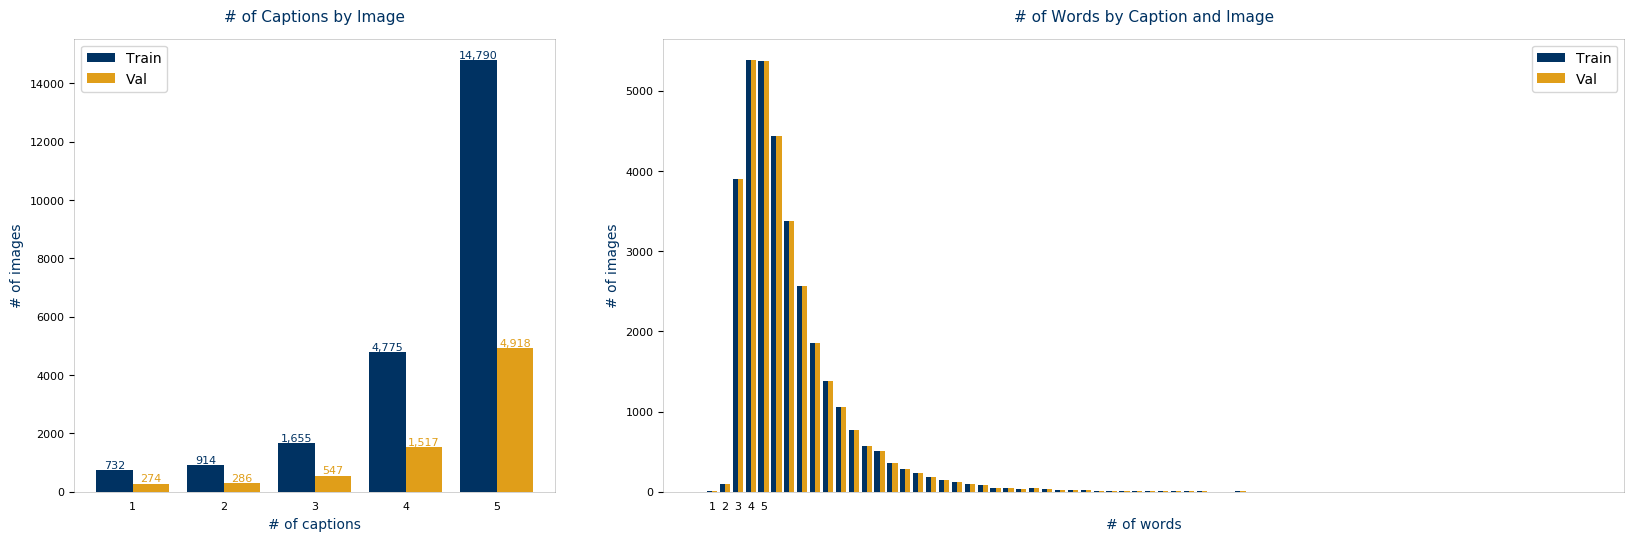

In [260]:
fig = plt.figure(figsize=(20, 6), dpi=100)

spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 2], wspace=0.15)

#####################################
## Captions by Image               ## 
#####################################
# count images by captions_count
vizwiz_vis_caps = vizwiz_vis_unique.groupby(by=['captions_count', 'type'], as_index=False).count() \
    .rename({'image_id': 'image_count'}, axis=1)

ax = fig.add_subplot(spec[0])
x = np.arange(len(vizwiz_vis_caps.captions_count.unique()))
width = 0.4

ax.bar(x, vizwiz_vis_caps.loc[vizwiz_vis_caps['type'] == 0, 'image_count'], width=width, label='Train', 
       color=ucb_palette['berkeley_blue'])
ax.bar(x + width, vizwiz_vis_caps.loc[vizwiz_vis_caps['type'] == 1, 'image_count'], width=width, label='Val', 
       color=ucb_palette['medalist'])

# fix the axis
ax.set_xticks(x + width / 2)
ax.set_xticklabels(vizwiz_vis_caps.captions_count.unique())

# show legend
ax.legend()

# axis styling
ax.set_title('# of Captions by Image', color = ucb_palette['berkeley_blue'], y = 1.02, 
    fontsize = 11, fontweight = 'light')
ax.set_xlabel('# of captions', fontsize = 10, ha='center', color = ucb_palette['berkeley_blue'])
ax.set_ylabel('# of images', fontsize = 10, ha='center', color = ucb_palette['berkeley_blue'])
ax.tick_params(bottom=False, which='major', labelsize=8)
setSpinesAlphaLineWidth(ax)

# show text label
for bar in ax.patches:
    bar_value = bar.get_height()
    text = f'{bar_value:,}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color, size=8)
    
    
#####################################
## Words by Image                  ## 
#####################################
# count images by words_count and type (Train or Val)
vizwiz_vis_words = vizwiz_vis[['image_id', 'words_count', 'type']].groupby(by=['words_count', 'type'], as_index=False).count() \
    .rename({'image_id': 'image_count'}, axis=1)

# insert zero words_count values for images that do not have image_count by Train (type == 0) by finding delta images between all and parts 
all = vizwiz_vis_words.words_count.unique()
parts = vizwiz_vis_words.loc[(vizwiz_vis_words.words_count.isin(all)) 
                            & (vizwiz_vis_words.type == 0), 'words_count'].to_numpy()
diff = np.setdiff1d(all, parts)
new = pd.DataFrame({'words_count': diff, 
                    'type': np.zeros(len(diff), dtype=int),
                    'image_count': np.zeros(len(diff), dtype=int)})

vizwiz_vis_words = vizwiz_vis_words.append(new)

# insert zero words_count values for images that do not have image_count by Val (type == 1) by finding delta images between all and parts 
parts = vizwiz_vis_words.loc[(vizwiz_vis_words.words_count.isin(all)) 
                            & (vizwiz_vis_words.type == 1), 'words_count'].to_numpy()
diff = np.setdiff1d(all, parts)
new = pd.DataFrame({'words_count': diff, 
                    'type': np.ones(len(diff), dtype=int),
                    'image_count': np.zeros(len(diff), dtype=int)})

vizwiz_vis_words = vizwiz_vis_words.append(new)
vizwiz_vis_words.sort_values(by=['words_count', 'type'], inplace=True)

ax = fig.add_subplot(spec[1])
x = np.arange(len(all))
width = 0.4

ax.bar(x, vizwiz_vis_words.loc[vizwiz_vis_words['type'] == 1, 'image_count'], width=width, label='Train', 
      color=ucb_palette['berkeley_blue'])
ax.bar(x + width, vizwiz_vis_words.loc[vizwiz_vis_words['type'] == 1, 'image_count'], width=width, label='Val', 
       color=ucb_palette['medalist'])

# fix the axis
ax.set_xticks(x + width / 2)
ax.set_xticklabels(vizwiz_vis_caps.captions_count.unique())

# show legend
ax.legend()

# axis styling
ax.set_title('# of Words by Caption and Image', color = ucb_palette['berkeley_blue'], y = 1.02, 
    fontsize = 11, fontweight = 'light')
ax.set_xlabel('# of words', fontsize = 10, ha='center', color = ucb_palette['berkeley_blue'])
ax.set_ylabel('# of images', fontsize = 10, ha='center', color = ucb_palette['berkeley_blue'])
ax.tick_params(bottom=False, which='major', labelsize=8)
setSpinesAlphaLineWidth(ax)
    
#fig.tight_layout()